In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()

def CNNClassifier(num_epochs=2, layers=1, dropout=0.15):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))

    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

## Exploring CNN parameters.

There are various hyperparameters of CNNs.

Using the same data from yesterday's dog/road dataset

First step: load in data and create training and test set.

In [ ]:
# load our data
data, labels = load_data()
inputs_train, inputs_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.2)
inputs_train = inputs_train.astype('float32')
inputs_test = inputs_test.astype('float32')
inputs_train /= 255.0
inputs_test /= 255.0

labels_train_numerical = categorical_to_numpy(labels_train)
labels_test_numerical = categorical_to_numpy(labels_test)

In [ ]:
len(labels)

1200

## Using a simple neural network

Use `MLPClassifier` to build simple neural network from scikit-learn

Adjusting complexity of model: using **number of neurons** and the **number of hidden layers**

**Example 1:**

Creating a a neural network with 1 hidden layer and 3 neurons:

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

Creating a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPClassifier(hidden_layer_sizes=(3, 3)) `

In [ ]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 10000)  ## How many hidden layers? How many neurons does this have?

# Fit the model
nnet.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(inputs_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)

MLP Testing Set Score:
86.66666666666667


### 1

Exploring different numbers of hidden layers, size of hidden layers, number of iterations using MLP classifier

In [ ]:
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 10000)  ## How many hidden layers? How many neurons does this have?

# Fit the model
nnet.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(inputs_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)

MLP Testing Set Score:
88.75


## Models for vision: Convolutional Neural Networks

###2

Convolutional neural networks (CNNs)work particularly well on problems to do with computer vision

Run:

`cnn = CNNClassifier(num_epochs=E, layers=L, dropout=D)`

Dropout: how many weights we set to 0 during training time (helps prevent overfitting)

In [ ]:
E = 10  # Number of epochs
L = 2   # Number of convolutional layers
D = 0.25  # Dropout rate
cnn = CNNClassifier(num_epochs=E, layers=L, dropout=D)


<ipython-input-1-a8d6e45d9b0d>:89: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)


## Training and Validation Curves

Important aspect of training neural networks: prevent overfitting

Model is overfitting when validation (or test) accuracy is lower than our training accuracy


1. **fit** the model on the training data and pass in some validation (or test) data to evaluate it

2. plot the history so that we can compare the training and validation accuracies

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)
```



###3

Plot train vs. validation curve for CNN model


Epoch 1/10
96/96 - 13s - loss: 0.5606 - accuracy: 0.7281 - val_loss: 0.4722 - val_accuracy: 0.8167 - 13s/epoch - 133ms/step
Epoch 2/10
96/96 - 0s - loss: 0.3854 - accuracy: 0.8521 - val_loss: 0.3436 - val_accuracy: 0.8750 - 437ms/epoch - 5ms/step
Epoch 3/10
96/96 - 0s - loss: 0.2856 - accuracy: 0.8813 - val_loss: 0.2947 - val_accuracy: 0.8833 - 459ms/epoch - 5ms/step
Epoch 4/10
96/96 - 0s - loss: 0.2268 - accuracy: 0.9052 - val_loss: 0.2611 - val_accuracy: 0.9083 - 422ms/epoch - 4ms/step
Epoch 5/10
96/96 - 0s - loss: 0.1952 - accuracy: 0.9240 - val_loss: 0.2878 - val_accuracy: 0.8958 - 452ms/epoch - 5ms/step
Epoch 6/10
96/96 - 0s - loss: 0.1931 - accuracy: 0.9208 - val_loss: 0.2557 - val_accuracy: 0.9125 - 422ms/epoch - 4ms/step
Epoch 7/10
96/96 - 0s - loss: 0.1676 - accuracy: 0.9333 - val_loss: 0.2666 - val_accuracy: 0.8917 - 423ms/epoch - 4ms/step
Epoch 8/10
96/96 - 0s - loss: 0.1429 - accuracy: 0.9448 - val_loss: 0.2847 - val_accuracy: 0.9042 - 417ms/epoch - 4ms/step
Epoch 9/10
96/9

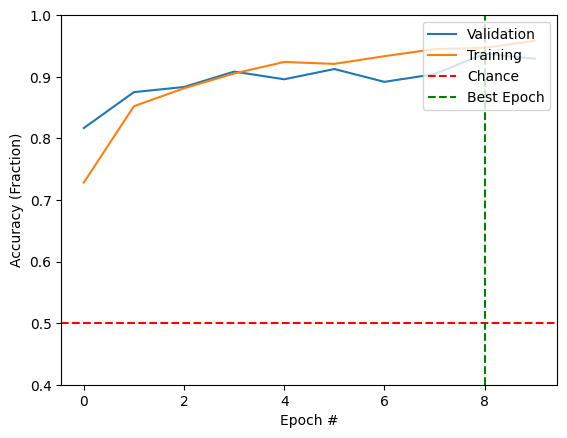

In [ ]:

labels_train_numerical = categorical_to_numpy(labels_train)
labels_test_numerical = categorical_to_numpy(labels_test)
history = cnn.fit(inputs_train, labels_train_numerical, validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)